<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/french.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 --version

Python 3.7.10


# Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K


# Data load and preprocessing

In [3]:
# data can be downloaded from
# however they are not in good format as delimiter is chosen badly
# people from Masaryk Uni can access the dataset via 
#https://drive.google.com/file/d/19eCVbFxIbs6uwe7w5MPsdcYNh0uILPfJ/view?usp=sharing
claim = pd.read_csv('/content/drive/MyDrive/Data/MTPL.csv')

In [4]:
claim.head()

,id,claims,expo,age,ac,power,gas,brand,area,dens,ct,truefreq
0,1,0,0.33,66,4,3,Regular,B12,B,83,BE,0.059941
1,2,0,0.08,31,1,7,Diesel,B1,A,34,BL,0.119216
2,3,0,0.92,60,6,5,Diesel,B1,C,223,AG,0.074344
3,4,0,1.00,66,4,2,Diesel,B1,C,283,FR,0.092829
4,5,0,0.63,63,3,5,Regular,B12,B,74,VS,0.049981


In [5]:
claim.shape

(500000, 12)

In [6]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        500000 non-null  int64  
 1   claims    500000 non-null  int64  
 2   expo      500000 non-null  float64
 3   age       500000 non-null  int64  
 4   ac        500000 non-null  int64  
 5   power     500000 non-null  int64  
 6   gas       500000 non-null  object 
 7   brand     500000 non-null  object 
 8   area      500000 non-null  object 
 9   dens      500000 non-null  int64  
 10  ct        500000 non-null  object 
 11  truefreq  500000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 45.8+ MB


In [7]:
# obect columns are not good for model training, so we change their
# datatype to category
numerics = ['int64', 'float64']
object_cols = claim.select_dtypes("object").columns  # select object columns
claim[object_cols] = claim[object_cols].astype('category')


In [8]:
claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        500000 non-null  int64   
 1   claims    500000 non-null  int64   
 2   expo      500000 non-null  float64 
 3   age       500000 non-null  int64   
 4   ac        500000 non-null  int64   
 5   power     500000 non-null  int64   
 6   gas       500000 non-null  category
 7   brand     500000 non-null  category
 8   area      500000 non-null  category
 9   dens      500000 non-null  int64   
 10  ct        500000 non-null  category
 11  truefreq  500000 non-null  float64 
dtypes: category(4), float64(2), int64(6)
memory usage: 32.4 MB


In [9]:
# numerical characteristics of dataset
claim.describe(exclude='category')

,id,claims,expo,age,ac,power,dens,truefreq
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,0.051966,0.506044,45.169664,6.568550,3.470314,1566.961430,0.111613
std,144337.711634,0.232503,0.353640,13.841937,5.436954,2.086814,3074.835538,0.077389
min,1.000000,0.000000,0.020000,18.000000,0.000000,1.000000,1.000000,0.004296
25%,125000.750000,0.000000,0.160000,34.000000,2.000000,2.000000,111.000000,0.072991
50%,250000.500000,0.000000,0.470000,44.000000,5.000000,3.000000,451.000000,0.091044
75%,375000.250000,0.000000,0.890000,54.000000,10.000000,4.000000,1753.000000,0.118862
max,500000.000000,3.000000,1.000000,90.000000,35.000000,12.000000,27000.000000,1.395911


In [10]:
# no empty / nan values
claim.isnull().sum() 

id          0
claims      0
expo        0
age         0
ac          0
power       0
gas         0
brand       0
area        0
dens        0
ct          0
truefreq    0
dtype: int64

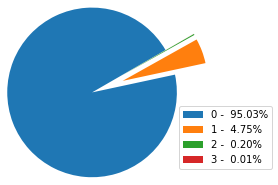

In [11]:
# pie plot showing the distribution of claim counts

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
dat = claim.claims.value_counts()

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


wedges, autotexts = ax.pie(dat, explode = [0,0.5,0.5,0.5], startangle = 30, radius = 1.3, textprops=dict(color="w"))

ax.legend(wedges, ['0 -  95.03%','1 -  4.75%','2 -  0.20%','3 -  0.01%'],
                    loc="lower left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.show()

In [12]:
# we have only three target labels
claim.claims.value_counts()/claim.shape[0] * 100

0    95.0306
1     4.7546
2     0.2024
3     0.0124
Name: claims, dtype: float64

In [13]:
# car owner age distribution
print(claim.age.unique().size)
np.sort(claim.age.unique())


73


array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])

In [14]:
# exposition period with maxium of 1 y, minimum 0.02 y and mean 0.51 y
print(np.min(claim.expo))
print(np.max(claim.expo))
print(round(np.mean(claim.expo), 2))

0.02
1.0
0.51


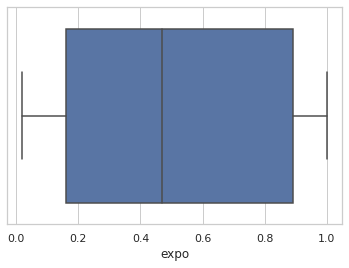

In [15]:
# boxplot for exposition period distribution
sns.set_theme(style="whitegrid")
sns.boxplot(x = 'expo', data = claim)

In [16]:
# 11 car brand categories
print(claim.brand.unique())

['B12', 'B1', 'B2', 'B13', 'B3', ..., 'B10', 'B5', 'B14', 'B6', 'B11']
Length: 11
Categories (11, object): ['B12', 'B1', 'B2', 'B13', ..., 'B5', 'B14', 'B6', 'B11']


In [17]:
# 6 area size categories
print(claim.area.unique())

['B', 'A', 'C', 'D', 'E', 'F']
Categories (6, object): ['B', 'A', 'C', 'D', 'E', 'F']


In [18]:
# 26 license plate categories (Swiss cantons)
print(claim.ct.unique())

['BE', 'BL', 'AG', 'FR', 'VS', ..., 'TI', 'BS', 'UR', 'AR', 'AI']
Length: 26
Categories (26, object): ['BE', 'BL', 'AG', 'FR', ..., 'BS', 'UR', 'AR', 'AI']


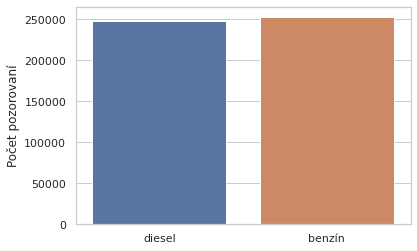

In [19]:
# Distribution of type of fuel
ax = countplot(data=claim,x='gas')
ax.set_xticklabels(["diesel","benzín"])
ax.set_ylabel("Počet pozorovaní")
ax.set_xlabel("")

show()

In [20]:
# drop unimportant columns, claims/expo is response, 
# truefreq we dont use in modelling, only on for evaluation
x = claim.drop(['id', 'claims', 'expo', 'truefreq'], axis = 1)
# x is dataset of all 8 features
x.head()

,age,ac,power,gas,brand,area,dens,ct
0,66,4,3,Regular,B12,B,83,BE
1,31,1,7,Diesel,B1,A,34,BL
2,60,6,5,Diesel,B1,C,223,AG
3,66,4,2,Diesel,B1,C,283,FR
4,63,3,5,Regular,B12,B,74,VS


In [21]:
# correlation between numerical features
x.corr()

,age,ac,power,dens
age,1.000000,-0.073371,0.042067,-0.005100
ac,-0.073371,1.000000,0.002280,-0.035581
power,0.042067,0.002280,1.000000,0.016526
dens,-0.005100,-0.035581,0.016526,1.000000


# Scaling and one-hot-encoding

In [22]:
onehot = OneHotEncoder()
gasenc = LabelEncoder()
minmax = MinMaxScaler(feature_range=(-1 , 1))

In [23]:
# transform area to numeric categories
x['area'] = x['area'].cat.codes


In [24]:
# transform dens to log dens (we follow the initial article of 
# M. V. Wuthrich - Data Analytics for Non-Life Insurance Pricing, 2020)
x['dens'] = np.log(x['dens'])

In [25]:
# correlation of numerical features 
# significant correlation between area and dens
x.corr()

,age,ac,power,area,dens
age,1.000000,-0.073371,0.042067,-0.030323,-0.030430
ac,-0.073371,1.000000,0.002280,-0.023891,-0.022357
power,0.042067,0.002280,1.000000,-0.026590,-0.025594
area,-0.030323,-0.023891,-0.026590,1.000000,0.968001
dens,-0.030430,-0.022357,-0.025594,0.968001,1.000000


In [26]:
# numerical we use min max scaler to map to interval [-1,1]
x[['age', 'ac', 'power', 'dens', 'area']] = minmax.fit_transform(x[['age', 'ac', 'power', 'dens', 'area']])

In [27]:
# gas is transformed into two categories, -1.5, +1.5
x['gas'] = x.gas.factorize()[0] - 0.5

In [28]:
# One hot encoding with drop first
x = pd.get_dummies(x, drop_first=True, columns = ['brand', 'ct'])

# Funkcie

In [79]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviance')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance
def limit_log(mu, N):
  result = []
  for i in range(len(N)):
    if (N[i] > 0):
      result.append(N[i] * np.log(N[i] / mu[i]))
    else:
      result.append(0)
  return np.asarray(result)

# deviance according to Wuthrix
def deviance(lambd, v, N, eps = False):
  if not eps:
    result = 2 *( lambd * v - N + limit_log(lambd * v, N)).mean()  
  else:
    result = (2 * v *( lambd - N + limit_log(lambd, N))).mean()
  return result

In [95]:
type(v)

pandas.core.series.Series

# Homogenny pripad

In [71]:
# target
y = claim.claims
# offset
v = claim.expo

In [72]:
# true frequency
truefreq = claim.truefreq
# true average frequency
lambda_star_mean = np.dot(truefreq, v) / v.sum()
print(lambda_star_mean)

0.10199107887858049


In [80]:
# deviancia truefreq
deviance(truefreq, v, y)

0.2772782297550223

In [81]:
%%time
# Homogenous portfolio frequency
lambda_hat = y.sum()/v.sum()
print(lambda_hat)

0.10269062235781508
CPU times: user 4.44 ms, sys: 35 µs, total: 4.48 ms
Wall time: 8.08 ms


In [75]:
# mean number of insurance claims
y.mean()

0.051966

In [82]:
# deviancia homogenous
deviance(lambda_hat, v, y)

0.29106463979989994

In [83]:
#eps
lh = np.ones(len(truefreq)) * lambda_hat
deviance(lh, v, truefreq, eps = True)

0.013439341841768367

In [78]:
# expected number of claims
av = (claim.truefreq * claim.expo ).mean()
print(av)

0.05161200003771397


# Modely

In [34]:
# lv is offset
lv = np.log(v) 
# train and valid set
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, shuffle = True)

## Deep

In [43]:
df = x
# hyperparametre
batch = 1000
epoch = 100

In [40]:
Design = tf.keras.Input(shape=(41,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(20, activation = 'tanh', name = 'Layer1')(Design)
layer2  = layers.Dense(15, activation= 'tanh',  name = 'Layer2')(layer1)
layer3  = layers.Dense(10, activation= 'tanh',  name = 'Layer3')(layer2)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
 bias_initializer = tf.keras.initializers.Constant(lambda_hat))(layer3)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
deep_full = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)

deep_full.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

deep_full.build(input_shape=(41,))
deep_full.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 41)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 20)           840         Design[0][0]                     
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 15)           315         Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 10)           160         Layer2[0][0]                     
____________________________________________________________________________________________

In [73]:
# initial first bad guess
'''
model = keras.Sequential([
                          layers.InputLayer(input_shape=(41,)),
                          layers.Dense(20, activation = 'tanh'),
                          layers.Dense(15, activation= 'tanh'),
                          layers.Dense(10, activation= 'tanh'),
                          layers.Dense(1, activation= 'linear'),
                          layers.Dense(units = 1, activation= 'exponential', trainable=False)

])
model.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))

'''

"\nmodel = keras.Sequential([\n                          layers.InputLayer(input_shape=(41,)),\n                          layers.Dense(20, activation = 'tanh'),\n                          layers.Dense(15, activation= 'tanh'),\n                          layers.Dense(10, activation= 'tanh'),\n                          layers.Dense(1, activation= 'linear'),\n                          layers.Dense(units = 1, activation= 'exponential', trainable=False)\n\n])\nmodel.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(\n    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))\n\n"

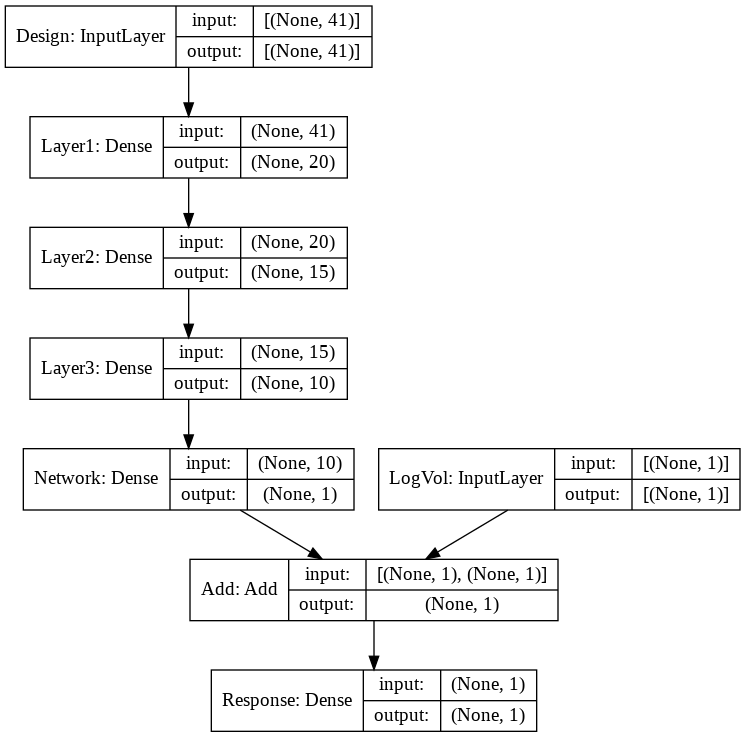

In [41]:
keras.utils.plot_model(deep_full, "multi_input_and_output_model.png", show_shapes=True)

### Full dataset

In [44]:
%%time

history = deep_full.fit(
    x = [df, lv],
    y = y,
    #x_train, y_train,
    #validation_data = (x_valid, y_valid),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/100
500/500 - 5s - loss: 0.2212
Epoch 2/100
500/500 - 1s - loss: 0.1943
Epoch 3/100
500/500 - 1s - loss: 0.1943
Epoch 4/100
500/500 - 1s - loss: 0.1925
Epoch 5/100
500/500 - 1s - loss: 0.1914
Epoch 6/100
500/500 - 1s - loss: 0.1908
Epoch 7/100
500/500 - 1s - loss: 0.1900
Epoch 8/100
500/500 - 1s - loss: 0.1897
Epoch 9/100
500/500 - 1s - loss: 0.1895
Epoch 10/100
500/500 - 1s - loss: 0.1894
Epoch 11/100
500/500 - 1s - loss: 0.1893
Epoch 12/100
500/500 - 1s - loss: 0.1892
Epoch 13/100
500/500 - 1s - loss: 0.1891
Epoch 14/100
500/500 - 1s - loss: 0.1891
Epoch 15/100
500/500 - 1s - loss: 0.1890
Epoch 16/100
500/500 - 1s - loss: 0.1890
Epoch 17/100
500/500 - 1s - loss: 0.1889
Epoch 18/100
500/500 - 1s - loss: 0.1889
Epoch 19/100
500/500 - 1s - loss: 0.1888
Epoch 20/100
500/500 - 1s - loss: 0.1888
Epoch 21/100
500/500 - 1s - loss: 0.1887
Epoch 22/100
500/500 - 1s - loss: 0.1887
Epoch 23/100
500/500 - 1s - loss: 0.1887
Epoch 24/100
500/500 - 1s - loss: 0.1887
Epoch 25/100
500/500 - 1s

In [45]:
deep_full.save('/content/drive/MyDrive/models/deep_full')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/deep_full/assets


In [ ]:

deep_full = keras.models.load_model('/content/drive/MyDrive/models/deep_full')

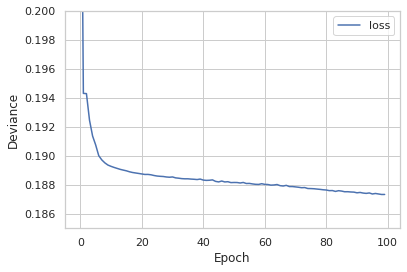

In [55]:
plot_loss(history, yran=[0.185, 0.2], val = False)

In [56]:
predictions = deep_full.predict([x,lv])

In [57]:
preds = predictions.flatten()
# mean of predicted claims
preds.mean()

0.05100592

In [58]:
preds.max()


1.0428671

In [84]:
# in sample deviance
deviance(preds / v, v, y)

0.2764431166951795

In [85]:
# eps
deviance(preds / v, v , truefreq, eps = True)

0.003798787393684862

In [ ]:
tf.keras.backend.set_epsilon(1e-7)
